# Getting starting with eesampling library

This jupyter notebook is an interactive tutorial. It walks through loading data, running the stratified sampling model, and plotting results. You'll run all the code yourself. Cells can be executed with `<shift><enter>`. If you feel so inspired, make edits to the code in these cells and dig deeper.


## Note on tutorial scope and related libraries

This tutorial assumes the reader has properly installed python and the eesampling package (pip install eesampling) and has a basic working knowledge of python syntax and usage. 

The `eesampling` library uses `pandas` data frames as its principle way of representing data, therefore all inputs and outputs are data frames; see [this tutorial](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) for information on how to use `pandas`.  The `plotnine` library is used to make visualizations which can be embedded in a Jupyter notebook or saved as .pngs; see [this website](https://plotnine.readthedocs.io/en/stable/) for information on `plotnine`.
    

# Background -- why this library

The `eesampling` library originated from a project lead by Recurve Analytics, Inc. and funded by the US Dept. of Energy designed to identify practical methods for analyzing energy efficiency which are robust to external shocks (e.g. COVID-19).  From June through September 2020, Recurve hosted a series of meetings with industry stakeholders to discuss methods for constructing comparison groups, with the goal of presenting a recommended standard method to the GRID working group, a subsidiary of the Linux Foundation for Energy.  During this time, Recurve developed Python software to implement stratified sampling and demonstrate its effectiveness in practice.  The `eesampling` library is the open-source Apache-licensed output of this process and is availabe to be used be anyone. 

There are three useful things you can do with this library:
- Construct a control group that is comparable to a treatment group, according to a specific stratification scheme
- Identify an optimal stratification scheme which minimizes error between treatment and control groups 
- Construct and view diagnostic plots to visualize the data and the stratification scheme

This notebook will take you through each step in the process.


# Setup

Run the following cells to install the required libraries to use this notebook:

In [25]:
!pip install eesampling pandas plotnine

/usr/local/lib/python2.7/dist-packages/cryptography/__init__.py:39: CryptographyDeprecationWarning: Python 2 is no longer supported by the Python core team. Support for it is now deprecated in cryptography, and will be removed in a future release.
  CryptographyDeprecationWarning,
  Using cached https://files.pythonhosted.org/packages/59/7e/bca6e6abbdc9a35e5f1c07e865aef6a4230da41514feb551ba07c48284f5/eesampling-0.7.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/db/83/7d4008ffc2988066ff37f6a0bb6d7b60822367dcb36ba5e39aa7801fda54/pandas-0.24.2-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/fe/49/7af942bc63277dfca6ad397415f4cff60789c56d173b1f7edf0bd30e27e0/plotnine-0.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3a/5f/47e578b3ae79e2624e205445ab77a1848acdaa2929a00eeef6b16eaaeb20/numpy-1.16.6-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/4f/a4/879454d49688e2

  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/d2/3d/fa76db83bf75c4f8d338c2fd15c8d33fdd7ad23a9b5e57eb6c5de26b430e/click-7.1.2-py2.py3-none-any.whl
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/14/df/479736ae1ef59842f512548bacefad1abed705e400212acba43f9b0fa556/attrs-20.2.0-py2.py3-none-any.whl
  Running setup.py bdist_wheel for eesampling ... done
  Stored in directory: /home/mariano/.cache/pip/wheels/1e/a3/03/d86373b045f98b89f456e6eac439edae22fd3e4e15a58c1f17
  Running setup.py bdist_wheel for statsmodels ... done
  Stored in directory: /home/mariano/.cache/pip/wheels/1f/c9/bb/085ae5991327cb08b1dabf0564a3f148d0cd9c1395933c8286
  Running setup.py bdist_wheel for subprocess32 ... done
  Stored in directory: /home/mariano/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786

# Problem definition

Typcailly there are two populations of meters: a **treatment group**, and a **comparison pool**.  The treatment group consists of those meters for which savings needs to be tracked, e.g. if they represent customers participating in an energy efficiency program.  The comparison pool consists of all of the available meters that are not part of the treatment group.  The goal is to select a **comparison group** which is a subset of the comparison_pool, such that the control group is **similar** to the treatment group.  The comparison group will then provide a realistic counterfactual compared to the treatment group and can be used to accurately estimate the impact of a program.

There are many ways to define similarity and many methods for constructing similar groups.  The stratified sampling approach was selected in particular because it offers a good balance in terms effectiveness, ease of implementation, and simplicity.  (Other methods e.g. site-based matching on Euclidean distance may eventually be added to this library; contributions welcome.)  We define stratified sampling as follows:

- Each meter is represented by a vector of numerical features, e.g. annual usage, summer peak usage, etc
- A small number of features, typically between 1 and 3 inclusive, are selected: this is the number of *dimensions*.
- The treatment group is divided up into a set of multidimensional bins according to a predefined binning configuration.
- The proportion of treatment meters present in each bin is computed.
- A set of meters is sampled from the comparison pool such that the sample is distributed amongst the bins in the same proportion as the treatment group.  The sample is called the comparison group.
- The treatment and comparison groups are compared using additional meter data, e.g. load shapes.
- (Optional) An optimal binning configuration is selected which minimizes error between treatment and control groups.


In order to use this library, it is therefore necessary to have the following data at hand:
- A data frame containing the treatment group, with one ID column, and a set of numerical feature columns, one row per meter;
- A data frame containing the comparison pool, in the same format;
- A data frame containing the treatment group data for equivalence, with one ID column, one feature name column, and one value column; e.g. for an annual monthly load shape, the feature name column might contain the month name, and there might be twelve rows per meter;
- A data frame containing the comparison pool data for equivalence, in the same format.

# Setting up input data

Ordinarily you would start with your own time-series meter data, but for our purposes we'll generate some very basic synthetic data.  Let's start with a function that generates twelve data points to represent monthly consumption, and adds a bit of random noise.

In [26]:
import warnings
warnings.simplefilter('ignore')

In [27]:
import numpy as np
import pandas as pd

In [28]:
def generate(winter_value, summer_value, id_number):
    step = (summer_value - winter_value) / 6
    
    monthly_energy = np.concatenate([np.arange(winter_value, summer_value, step), 
                                     np.arange(summer_value, winter_value, -1*step)])
    noise = np.random.random(12) * 0.2 * np.abs(winter_value - summer_value)
    months = np.arange(12)+1
    return pd.DataFrame({'id': f"id_{id_number}",
                          'month': months, 
                          'value': monthly_energy + noise})

We now have a way of generating synethetic monthly data which varies linearly between a specified summer and winter value, with random noise added.  If we run this code, it produces a synthetic meter trace as follows:

In [4]:
generate(0, 1, 1)

,id,month,value
0,id_1,1,0.187904
1,id_1,2,0.296035
2,id_1,3,0.520544
3,id_1,4,0.673819
4,id_1,5,0.840877
5,id_1,6,0.900477
6,id_1,7,1.083329
7,id_1,8,0.931173
8,id_1,9,0.792159
9,id_1,10,0.698137


Now we'll generate two populations of meters, one to represent a treatment group and to represent a comparison pool, i.e. the set of meters from which we will draw the comparison group.  We'll just specify random values for the summer and winter consumptions values, however we'll bias the treatment group so that it has higher consumption on average compared to the comparison pool, in order to make the stratified sampling task a bit more realistic, because treatment groups often have different energy consumption patterns compared to the underlying base population, i.e. the comparison pool.

We'll generate a treatment group of 1000 meters and a comparison pool of 10000 meters (this code may take up to one minute to run).  Following that we'll plot a subset of the data to demonstrate how the groups differ:

In [89]:
df_pool = pd.concat([generate(np.random.lognormal(0,0.2), np.random.lognormal(0,0.2), i) for i in range(10000)])
df_treatment = pd.concat([generate(np.random.lognormal(0.1, 0.1), np.random.lognormal(0.1, 0.1), i) for i in range(1000)])

In [90]:
from plotnine import  *
import plotnine

In [91]:
df_meters_all = pd.concat([df_treatment.assign(set='treatment'), df_pool.assign(set='pool')])
df_meters_subset = pd.concat([df_treatment[df_treatment['id'].isin(df_treatment['id'].drop_duplicates().sample(100))].assign(set='treatment'),
                df_pool[df_pool['id'].isin(df_pool['id'].drop_duplicates().sample(100))].assign(set='pool')])

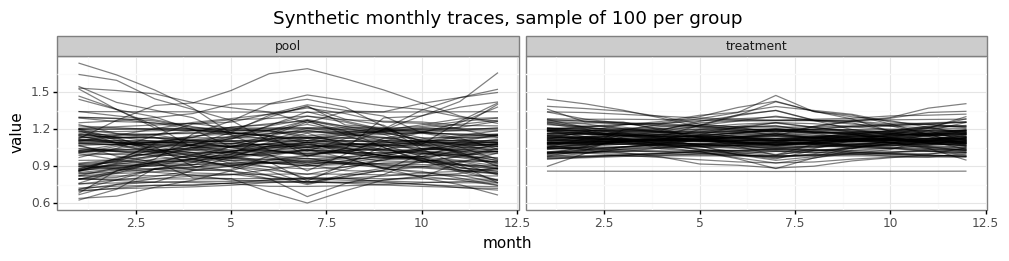

<ggplot: (8736844849160)>

In [93]:
plotnine.options.figure_size = (12,2)
ggplot(df_meters_subset, aes(x='month', y='value', group='id')) + geom_line(alpha=0.5) + theme_bw() + facet_wrap("~set", nrow=1) + ggtitle("Synthetic monthly traces, sample of 100 per group")

We'll use this data directly when computing equivalence later on.  In order to stratified sampling, however, we need to represent the data as a set of features, such that we have one column per feature, and one row per meter.  

Let's compute two features for the data -- total consumption in January, and total consumption in July.  The idea is that these features are a good way to summarize the differences between meters, therefore when selecting features one would aim to pick features that are independent from one another, and have a wide span.  (Other techniques such as principle component analysis could be used here as well.)  The plot below shows the data following the ranges we specified above along with random noise, with the treatment group having higher average usage than the comparison pool.  Our goal is to select a set of meters from the pool that have a similar distribution compared to the treatment group.  

In [111]:
df_features = df_meters_all.groupby(['id', 'set']).apply(lambda x: pd.Series({'summer_usage': x[x.month==7].value.sum(), 
                                                                              'winter_usage': x[x.month==1].value.sum()})).reset_index()
df_features_treatment = df_features[df_features['set']=='treatment']
df_features_pool = df_features[df_features['set']=='pool']


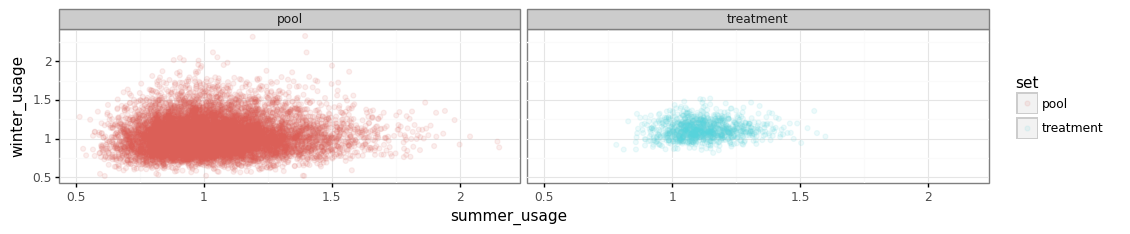

<ggplot: (-9223363299928708366)>

In [95]:
ggplot(df_features, aes(x='summer_usage', y='winter_usage', color='set')) + geom_point(alpha=0.1) + facet_wrap("~set") + theme_bw()

# Stratified sampling usage overview 

To use stratified sampling, you must supply input data, a list of input columns to stratify on, and some configuration, according to the example below.   Additionally, you have the option of using the library to select an optimal configuration for you.  We'll first demonstrate the basic usage of the model, in which you supply all of the configuration information.

In [128]:
from eesampling.model import StratifiedSampling

In [118]:
model = StratifiedSampling()
# specify number of bins, range cutoffs, whether to used equal-width or equal-proportion bins
model.add_column('summer_usage', n_bins=8, min_value_allowed=0, max_value_allowed=2, fixed_width=False)
model.add_column('winter_usage', n_bins=8, min_value_allowed=0, max_value_allowed=2, fixed_width=False)

In [119]:
model.fit_and_sample(df_features_treatment, df_features_pool, n_samples_approx=1000)

In [152]:
# final comparison group
model.data_sample.df



,id,set,summer_usage,winter_usage,_bin,_bin_label,_outlier_bin
1285,id_2047,pool,1.064429,1.087319,MultBin: summer_usage_001__winter_usage_001,summer_usage_001__winter_usage_001,False
5608,id_5586,pool,1.096047,1.027695,MultBin: summer_usage_001__winter_usage_001,summer_usage_001__winter_usage_001,False
5778,id_5724,pool,1.020110,1.112195,MultBin: summer_usage_001__winter_usage_001,summer_usage_001__winter_usage_001,False
4031,id_4295,pool,1.050738,1.040949,MultBin: summer_usage_001__winter_usage_001,summer_usage_001__winter_usage_001,False
5373,id_5393,pool,1.057609,1.141584,MultBin: summer_usage_001__winter_usage_001,summer_usage_001__winter_usage_001,False
...,...,...,...,...,...,...,...
8658,id_8080,pool,0.944998,1.378514,MultBin: summer_usage_000__winter_usage_003,summer_usage_000__winter_usage_003,False
6259,id_6117,pool,1.498374,0.867592,MultBin: summer_usage_003__winter_usage_000,summer_usage_003__winter_usage_000,False
7730,id_7320,pool,1.468506,0.844535,MultBin: summer_usage_003__winter_usage_000,summer_usage_003__winter_usage_000,False
5195,id_5247,pool,1.510234,1.408796,MultBin: summer_usage_003__winter_usage_003,summer_usage_003__winter_usage_003,False


In [153]:
# bin count
model.diagnostics().count_bins()


,bin,n_treatment,n_pct_treatment,n_pool,n_pct_pool,n_sampled,n_pct_sampled
0,MultBin: summer_usage_001__winter_usage_001,356,0.356,1065,0.138528,1061,0.357119
1,MultBin: summer_usage_001__winter_usage_002,184,0.184,549,0.071410,548,0.184450
2,MultBin: summer_usage_002__winter_usage_001,141,0.141,495,0.064386,420,0.141367
3,MultBin: summer_usage_001__winter_usage_000,84,0.084,1107,0.143991,250,0.084147
4,MultBin: summer_usage_002__winter_usage_002,63,0.063,216,0.028096,187,0.062942
5,MultBin: summer_usage_000__winter_usage_001,46,0.046,1050,0.136576,137,0.046112
6,MultBin: summer_usage_000__winter_usage_002,29,0.029,562,0.073101,86,0.028946
7,MultBin: summer_usage_001__winter_usage_003,24,0.024,206,0.026795,71,0.023898
8,MultBin: summer_usage_000__winter_usage_000,24,0.024,1125,0.146332,71,0.023898
9,MultBin: summer_usage_002__winter_usage_000,21,0.021,516,0.067118,62,0.020868


# Viewing diagnostic plots 

Once the model has been fit, you can view several plots which will show the treatment group, comparison pool, and the final sample (i.e. the comparison group).  If the model has worked correctly, then the sample should be distributed similarly to the treatment group.  There are three plots available:

1. Histograms, showing the distribution of each stratification parameter in one dimension;
2. Scatter plots, showing an XY-plot of data points for each pair of dimensions;
3. Quantile plots with equivalence, showing the quantile distribution of each dimension, along with t-test and ks-test p-values comparison the treatment and comparison groups.  

The t- and ks-tests can be used as a measure of equivalence, however we recommend using equivalence-based optimization discussed below for better results in practice.  

In [131]:
d = model.diagnostics()

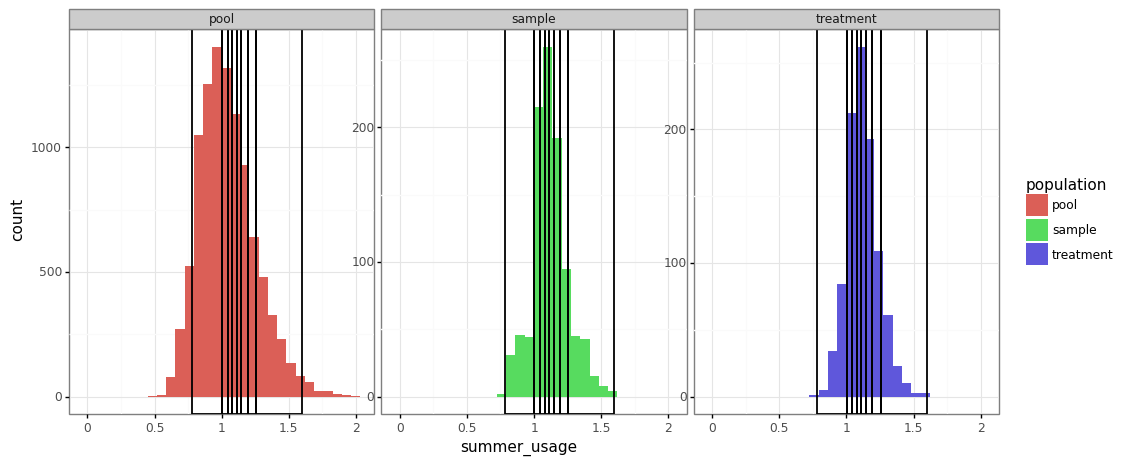

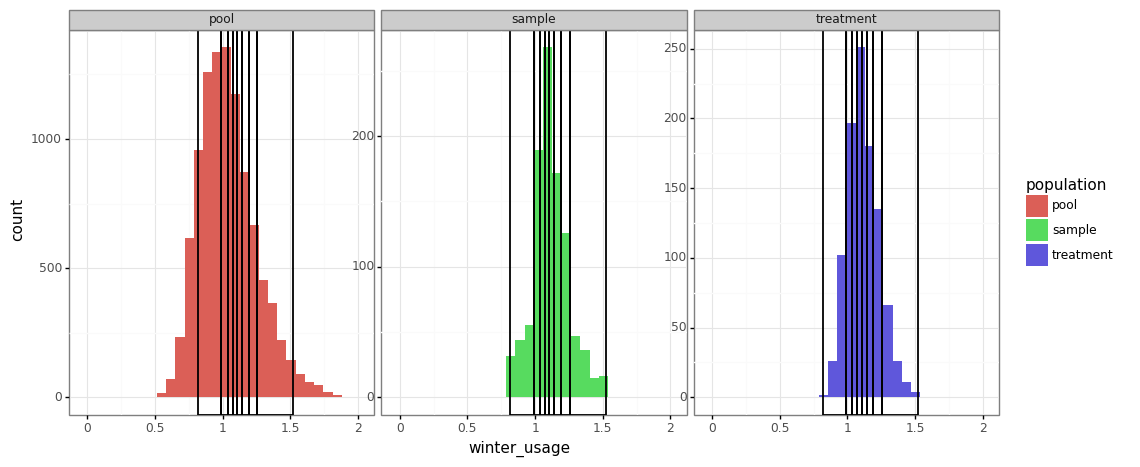

[<ggplot: (8736837548471)>, <ggplot: (8736839206611)>]

In [133]:
d.histogram()

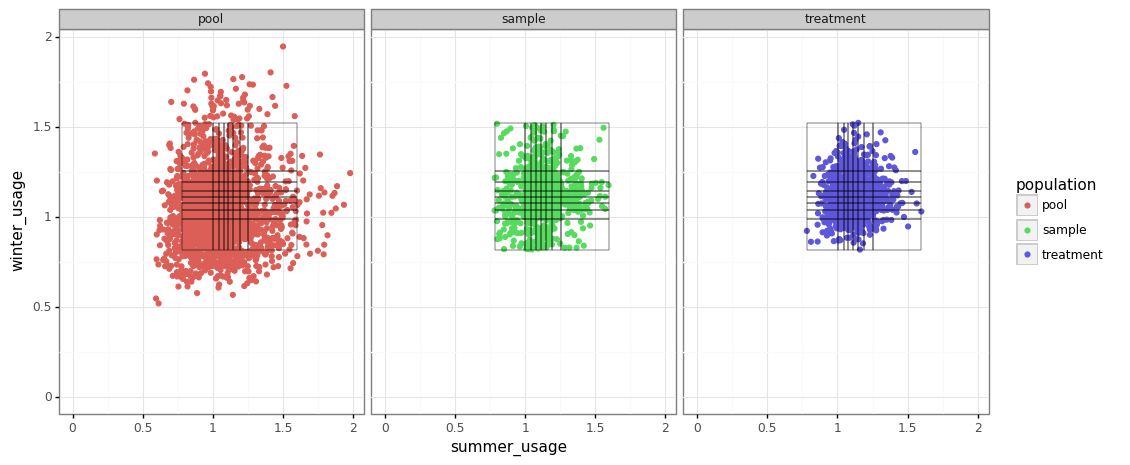

[<ggplot: (8736837154024)>]

In [130]:
d.scatter()

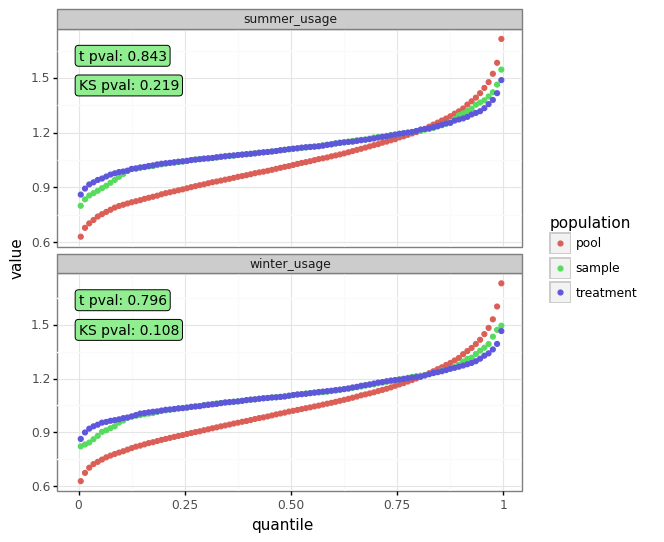

<ggplot: (8736839421395)>

In [127]:
d.quantile_equivalence()

# Empirical equivalence-based optimization

We have found t-stat and ks-stat to be imperfect mechanisms for assessing equivalence of treatment and comparison  populations and developed an additional method which has the following goals:

- Define a condensed data representation for metering data, e.g. monthly consumption, hourly load shape, hourly load shape by month, etc.
- Prepare condensed data frames for treatment group and comparison pool 
- Prepare a stratified sampling configuration as above and compute a comparison group
- Determine the distance between the condensed treatment group data and condensed control group data
- Iterate over a range of possible stratified sampling configurations and select the configuration which has the minimum distance.

In this example we can use the original monthly data that we generated above:

In [138]:
df_meters_all.set.value_counts()

pool         120000
treatment     12000
Name: set, dtype: int64

In [142]:
from eesampling.bin_selection import StratifiedSamplingBinSelector
from eesampling import StratifiedSampling

In [147]:
model = StratifiedSampling()
model.add_column('summer_usage')
model.add_column('winter_usage')

In [154]:
selector = StratifiedSamplingBinSelector(model,
    df_features_treatment,
    df_features_pool,
    df_meters_all,
    equivalence_groupby_col="month",
    equivalence_value_col="value",
    equivalence_id_col="id",
    min_n_bins=4,
    max_n_bins=6,
    random_seed=1,
    how='chisquare'
)

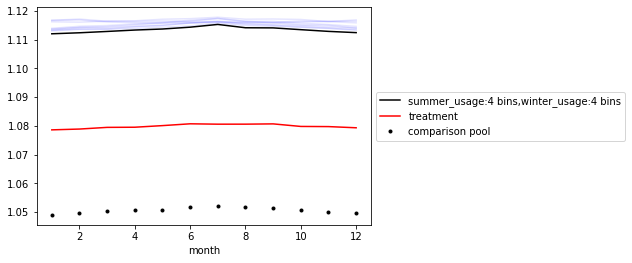

In [156]:
selector.plot_records_based_equiv_average()

... what happened here?